In [1]:
from fastai.vision.all import *
from sklearn.model_selection import StratifiedKFold

from ipyexperiments.ipyexperiments import IPyExperimentsPytorch
import timm
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm
from timm.models import safe_model_name, set_fast_norm

In [2]:
set_seed(42); set_fast_norm()
warnings.filterwarnings('ignore')

## Config

In [6]:
DATA_PATH = Path('/data/')
CSV_PATH = DATA_PATH/'train.csv'
IMAGE_FOLDER = DATA_PATH/'train'
FOLDS_PATH = DATA_PATH/'train_folds.csv'

LABELS = sorted(['broken', 'pure', 'discolored', 'silkcut'])
labels_class_map = {v:k for k,v in enumerate(LABELS)}
labels_class_map_rev = {v:k for k,v in labels_class_map.items()}

VIEWS = sorted(['top', 'bottom'])
views_class_map = {v:k for k,v in enumerate(VIEWS)}
views_class_map_rev = {v:k for k,v in views_class_map.items()}

VERSION = "NB_EXP_V2_011"
MODEL = "tf_efficientnetv2_m_in21ft1k"
BS = 32; SZ = 288

MODEL_FOLDER = Path(f"/runs/{VERSION}/")
MODEL_FOLDER.mkdir(exist_ok=True)

In [7]:
folds = pd.read_csv(FOLDS_PATH)
folds['fold'] = folds['fold'].astype(int)
folds.head()

,seed_id,view,image,label,fold
0,0,top,train/00000.png,broken,0
1,1,bottom,train/00001.png,pure,3
2,3,top,train/00003.png,broken,2
3,4,top,train/00004.png,pure,3
4,5,top,train/00005.png,discolored,4


## Define Dataset

In [8]:
def get_dls(fold:int):
    folds['is_valid'] = folds['fold'] == fold
    item_tfms = [Resize(SZ+16, method=ResizeMethod.Squish), ToTensor]

    augments = aug_transforms(do_flip=True, flip_vert=True, max_rotate=360, max_zoom=1.33, max_lighting=0.1, 
                              p_affine=0.5,  p_lighting=0.5, pad_mode="zeros", xtra_tfms=[RandomErasing(p=0.75)])
    batch_tfms = [IntToFloatTensor, RandomResizedCrop(SZ, min_scale=0.72), *augments, Normalize.from_stats(*imagenet_stats)]
    
    dblock = DataBlock(
        blocks     = (ImageBlock, CategoryBlock(vocab=LABELS)),
        splitter   = ColSplitter(col='is_valid'),
        get_x      = ColReader('image', pref=DATA_PATH),
        get_y      = [ColReader('label')],
        item_tfms  = item_tfms,
        batch_tfms = batch_tfms )
    
    dls = dblock.dataloaders(folds, bs=BS)
    return dls

## Visualization

In [9]:
dls = get_dls(0)

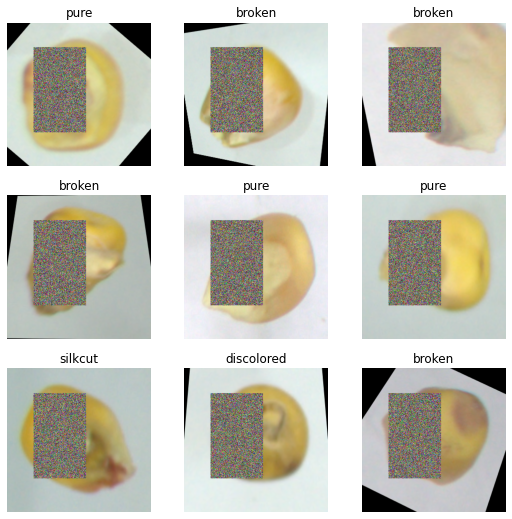

In [10]:
dls.show_batch()

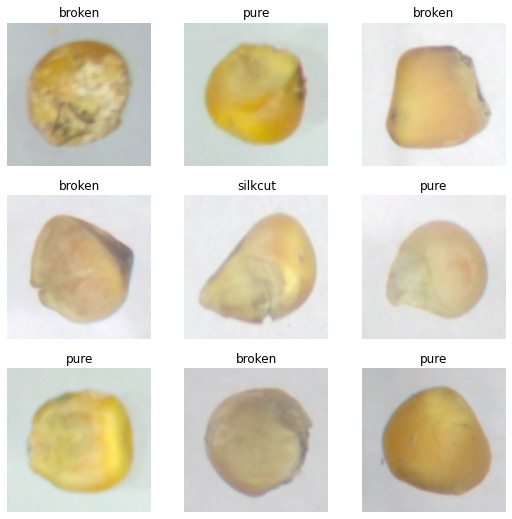

In [11]:
dls.valid.show_batch()

## Learner

In [12]:
def get_learner(fold, model_name, pretrained, **kwargs):
    dls = get_dls(fold)
    
    model = timm.create_model(model_name, pretrained=pretrained, **kwargs)
    model = nn.Sequential(model, nn.Dropout(0.15), nn.Linear(model.num_classes, len(LABELS)))
    
    learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy]).to_fp16()
    return dls, learn

In [13]:
# with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
#     dls, learn = get_learner(0, MODEL, pretrained=True)
#     learn.unfreeze()
#     print(learn.lr_find())

In [14]:
# LR = 3e-4
# learn.recorder.plot_lr_find()
# plt.axvline(LR)

## Run !

In [15]:
EP = 16; LR = 3e-4
KERNEL_TYPE = f"{MODEL}_{SZ}_bs{BS}_ep{EP}_lr{np.format_float_scientific(LR, trim='-').replace('-','')}_mixup_fastai"
print(KERNEL_TYPE)

tf_efficientnetv2_m_in21ft1k_288_bs32_ep16_lr3e04_mixup_fastai


In [16]:
def training_loop(fold):
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
        print()
        print('*' * 100)
        print(f'Training fold {fold}')
        print('*' * 100)

        cbs = [SaveModelCallback(monitor="accuracy", comp=np.greater), MixUp(alpha=0.4)]
        
        dls, learn = get_learner(fold, MODEL, pretrained=True)
        learn.unfreeze()
            
        learn.fit_one_cycle(EP, LR, cbs=cbs)

        learn = learn.load("model")
        learn = learn.to_fp32()

        dirpath = MODEL_FOLDER/f'{KERNEL_TYPE}_CV_{fold_idx}'
        learn.save(dirpath, with_opt=False)

In [17]:
for fold_idx in range(5):
    training_loop(fold_idx)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


****************************************************************************************************
Training fold 0
****************************************************************************************************


epoch,train_loss,valid_loss,accuracy,time
0,0.979540,0.767613,0.684119,01:37
1,0.890523,0.655425,0.743106,01:37
2,0.882319,0.671140,0.741012,01:37
3,0.872523,0.642000,0.739616,01:37
4,0.859770,0.691165,0.727400,01:37
5,0.860647,0.624238,0.759511,01:37
6,0.805328,0.585647,0.769284,01:37
7,0.795912,0.561264,0.774171,01:38
8,0.763378,0.526484,0.785340,01:37
9,0.763117,0.530171,0.791274,01:38


Better model found at epoch 0 with accuracy value: 0.6841186881065369.
Better model found at epoch 1 with accuracy value: 0.743106484413147.
Better model found at epoch 5 with accuracy value: 0.7595113515853882.
Better model found at epoch 6 with accuracy value: 0.7692844867706299.
Better model found at epoch 7 with accuracy value: 0.7741710543632507.
Better model found at epoch 8 with accuracy value: 0.7853403091430664.
Better model found at epoch 9 with accuracy value: 0.7912740111351013.
Better model found at epoch 10 with accuracy value: 0.7926701307296753.
Better model found at epoch 11 with accuracy value: 0.7979057431221008.
Better model found at epoch 12 with accuracy value: 0.801047146320343.
CPU: 816/54/3711 MB | GPU: 3144/6278/4817 MB | Time 0:26:09.658 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


*********************************************************************************************

epoch,train_loss,valid_loss,accuracy,time
0,0.988099,0.791311,0.689703,01:37
1,0.892725,0.636455,0.759162,01:37
2,0.876791,0.684411,0.719721,01:37
3,0.879723,0.680087,0.731588,01:37
4,0.841821,0.612574,0.756370,01:37
5,0.848805,0.600589,0.771030,01:37
6,0.811825,0.557663,0.778709,01:37
7,0.812340,0.546229,0.783246,01:37
8,0.761792,0.534504,0.795113,01:37
9,0.776545,0.534196,0.797557,01:37


Better model found at epoch 0 with accuracy value: 0.6897033452987671.
Better model found at epoch 1 with accuracy value: 0.7591623067855835.
Better model found at epoch 5 with accuracy value: 0.7710296511650085.
Better model found at epoch 6 with accuracy value: 0.7787085771560669.
Better model found at epoch 7 with accuracy value: 0.7832460999488831.
Better model found at epoch 8 with accuracy value: 0.7951134443283081.
Better model found at epoch 9 with accuracy value: 0.7975566983222961.
Better model found at epoch 11 with accuracy value: 0.8013961315155029.
Better model found at epoch 12 with accuracy value: 0.8101221919059753.
Better model found at epoch 13 with accuracy value: 0.8153577446937561.
CPU: 22/375/3733 MB | GPU: 2850/6278/4817 MB | Time 0:26:06.934 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


*******************************************************************************************

epoch,train_loss,valid_loss,accuracy,time
0,0.993701,0.760286,0.696927,01:37
1,0.876237,0.654196,0.734637,01:37
2,0.883873,0.650727,0.753142,01:36
3,0.872231,0.668513,0.737779,01:36
4,0.840041,0.668792,0.725908,01:37
5,0.840856,0.601169,0.761173,01:37
6,0.809947,0.592198,0.770950,01:37
7,0.803275,0.556115,0.782123,01:37
8,0.759632,0.551961,0.781774,01:37
9,0.762713,0.527621,0.792598,01:37


Better model found at epoch 0 with accuracy value: 0.6969273686408997.
Better model found at epoch 1 with accuracy value: 0.7346368432044983.
Better model found at epoch 2 with accuracy value: 0.7531424760818481.
Better model found at epoch 5 with accuracy value: 0.7611731886863708.
Better model found at epoch 6 with accuracy value: 0.7709497213363647.
Better model found at epoch 7 with accuracy value: 0.7821229100227356.
Better model found at epoch 9 with accuracy value: 0.792597770690918.
Better model found at epoch 10 with accuracy value: 0.7988826632499695.
Better model found at epoch 12 with accuracy value: 0.8037709593772888.
Better model found at epoch 13 with accuracy value: 0.8062151074409485.
CPU: -26/376/3706 MB | GPU: 2852/6274/4821 MB | Time 0:26:03.395 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


*******************************************************************************************

epoch,train_loss,valid_loss,accuracy,time
0,0.985614,0.711698,0.721369,01:37
1,0.881737,0.663429,0.732542,01:37
2,0.918392,0.626750,0.746858,01:37
3,0.879624,0.637295,0.750349,01:37
4,0.870438,0.623977,0.757682,01:37
5,0.855234,0.614435,0.758729,01:38
6,0.835699,0.577282,0.768855,01:37
7,0.812236,0.514908,0.797486,01:37
8,0.776540,0.522932,0.788757,01:37
9,0.754932,0.522748,0.792598,01:37


Better model found at epoch 0 with accuracy value: 0.7213687300682068.
Better model found at epoch 1 with accuracy value: 0.7325419187545776.
Better model found at epoch 2 with accuracy value: 0.7468575239181519.
Better model found at epoch 3 with accuracy value: 0.7503491640090942.
Better model found at epoch 4 with accuracy value: 0.7576815485954285.
Better model found at epoch 5 with accuracy value: 0.7587290406227112.
Better model found at epoch 6 with accuracy value: 0.7688547372817993.
Better model found at epoch 7 with accuracy value: 0.7974860072135925.
Better model found at epoch 10 with accuracy value: 0.8020251393318176.
Better model found at epoch 11 with accuracy value: 0.8037709593772888.
Better model found at epoch 14 with accuracy value: 0.806913435459137.
CPU: 45/359/3752 MB | GPU: 2856/6276/4821 MB | Time 0:26:10.976 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


*********************

epoch,train_loss,valid_loss,accuracy,time
0,0.958375,0.736195,0.708101,01:37
1,0.916399,0.616954,0.763617,01:37
2,0.886634,0.653861,0.745810,01:37
3,0.875936,0.636074,0.752444,01:37
4,0.844629,0.617062,0.741969,01:37
5,0.853439,0.619647,0.756983,01:37
6,0.830173,0.550810,0.783170,01:37
7,0.810785,0.552307,0.786313,01:38
8,0.781925,0.521501,0.792947,01:37
9,0.785637,0.520154,0.786662,01:38


Better model found at epoch 0 with accuracy value: 0.7081005573272705.
Better model found at epoch 1 with accuracy value: 0.7636173367500305.
Better model found at epoch 6 with accuracy value: 0.7831704020500183.
Better model found at epoch 7 with accuracy value: 0.7863128781318665.
Better model found at epoch 8 with accuracy value: 0.7929469347000122.
Better model found at epoch 10 with accuracy value: 0.8013268113136292.
Better model found at epoch 11 with accuracy value: 0.8048184514045715.
Better model found at epoch 12 with accuracy value: 0.8118016719818115.
Better model found at epoch 14 with accuracy value: 0.8142458200454712.
CPU: 197/202/3908 MB | GPU: 2854/6278/4817 MB | Time 0:26:14.094 | (Consumed/Peaked/Used Total)


In [18]:
@Transform
def hflip(x: TensorTypes): return x.flip(3)

@Transform
def vflip(x: TensorTypes): return x.flip(2)

In [19]:
folds_val_score = []

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold in range(5):
        CHECKPOINT = MODEL_FOLDER/(KERNEL_TYPE + f"_CV_{fold}.pth")
        print(f'=> load from : {CHECKPOINT}')
        
        dls, learn = get_learner(fold, MODEL, pretrained=False)

        learn.model.load_state_dict(torch.load(CHECKPOINT))

        tst_dl = dls.valid.new()
        
        tst_dl_hflip = dls.valid.new()
        tst_dl_hflip.after_batch.add(hflip)
        
        tst_dl_vflip = dls.valid.new()
        tst_dl_vflip.after_batch.add(vflip)
        
        tst_dl_hlip_vflip = dls.valid.new()
        tst_dl_hlip_vflip.after_batch.add([hflip,vflip])
            
        dls = [tst_dl,tst_dl_hflip,tst_dl_vflip,tst_dl_hlip_vflip]
        n = len(dls)
        learn([event.before_fit, event.before_epoch])
        
        aug_preds = []
        with learn.no_mbar():
            if hasattr(learn,'progress'): learn.progress.mbar = master_bar(list(range(n)))
            
            for i in learn.progress.mbar if hasattr(learn,'progress') else range(n):
                learn.epoch = i
                with dls[i].dataset.set_split_idx(1): preds,targs = learn.get_preds(dl=dls[i], inner=True)
                aug_preds.append(preds[None])
        
        learn.epoch = n
        
        aug_preds = torch.cat(aug_preds)
        aug_preds = aug_preds.mean(0)
        acc = accuracy(aug_preds, targs).item()
        print(f"* Accuracy : {acc}")
        print()
        
        folds_val_score.append(acc)
        learn(event.after_fit)
        
           
print()
print('*' * 100)
print(f'Run summary: ')
print('*' * 100)
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)

=> load from : /runs/NB_EXP_V2_011/tf_efficientnetv2_m_in21ft1k_288_bs32_ep16_lr3e04_mixup_fastai_CV_0.pth


* Accuracy : 0.8020942211151123

=> load from : /runs/NB_EXP_V2_011/tf_efficientnetv2_m_in21ft1k_288_bs32_ep16_lr3e04_mixup_fastai_CV_1.pth


* Accuracy : 0.8122164011001587

=> load from : /runs/NB_EXP_V2_011/tf_efficientnetv2_m_in21ft1k_288_bs32_ep16_lr3e04_mixup_fastai_CV_2.pth


* Accuracy : 0.8152933120727539

=> load from : /runs/NB_EXP_V2_011/tf_efficientnetv2_m_in21ft1k_288_bs32_ep16_lr3e04_mixup_fastai_CV_3.pth


* Accuracy : 0.8097066879272461

=> load from : /runs/NB_EXP_V2_011/tf_efficientnetv2_m_in21ft1k_288_bs32_ep16_lr3e04_mixup_fastai_CV_4.pth


* Accuracy : 0.8166899681091309

CPU: 452/126/4175 MB | GPU: 394/1034/2359 MB | Time 0:02:13.243 | (Consumed/Peaked/Used Total)

****************************************************************************************************
Run summary: 
****************************************************************************************************
folds score:  [0.80209, 0.81222, 0.81529, 0.80971, 0.81669]
Avg: 0.81120
Std: 0.00516
